In [ ]:
# 📘 Object Detection on COCO - Compare YOLOv8, YOLOv11, SSD, and Faster R-CNN

# ✅ SECTION 1: Install and Import
!pip install -q ultralytics pycocotools

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 27.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 63.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 91.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 58.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 21.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 8.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 60.2 MB/s eta 0:00:00


In [ ]:
import torch
import torchvision
import torchvision.transforms as transforms
from torchvision.models.detection import fasterrcnn_resnet50_fpn, ssd300_vgg16
from torchvision.datasets import CocoDetection
from torch.utils.data import DataLoader
from PIL import Image, ImageDraw
import os, json
from tqdm import tqdm
from pycocotools.coco import COCO
from pycocotools.cocoeval import COCOeval
import numpy as np
import matplotlib.pyplot as plt
from ultralytics import YOLO
import pandas as pd


Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


In [ ]:
from tqdm import tqdm
from torchvision import transforms as T

In [ ]:
transform = T.ToTensor()
subset = torchvision.datasets.CocoDetection(
    root="data/coco/val2017",
    annFile="data/coco/annotations/instances_val2017.json",
    transform=transform
)

loading annotations into memory...
Done (t=0.72s)
creating index...
index created!


In [ ]:
# ✅ Setup paths
os.makedirs("data/coco/images", exist_ok=True)
os.makedirs("results", exist_ok=True)


In [ ]:
# ✅ Download and load COCO validation set
!curl -LO http://images.cocodataset.org/zips/val2017.zip
!unzip -q val2017.zip -d data/coco/
!curl -LO http://images.cocodataset.org/annotations/annotations_trainval2017.zip
!unzip -q annotations_trainval2017.zip -d data/coco/

coco = COCO("data/coco/annotations/instances_val2017.json")
transform = transforms.ToTensor()
subset = CocoDetection(
    root="data/coco/val2017",
    annFile="data/coco/annotations/instances_val2017.json",
    transform=transform
)

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  777M  100  777M    0     0  31.8M      0  0:00:24  0:00:24 --:--:-- 32.8M
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  241M  100  241M    0     0  51.7M      0  0:00:04  0:00:04 --:--:-- 53.8M
loading annotations into memory...
Done (t=0.65s)
creating index...
index created!
loading annotations into memory...
Done (t=0.66s)
creating index...
index created!


In [ ]:
img_ids = list(set([ann['image_id'] for _, anns in subset for ann in anns]))[:100]


In [ ]:
img_ids = list(set([ann['image_id'] for _, anns in subset for ann in anns]))[:10]
coco = COCO("data/coco/annotations/instances_val2017.json")



loading annotations into memory...
Done (t=0.81s)
creating index...
index created!


In [ ]:
# ✅ Define a transformation for detection models
faster_transform = T.Compose([T.ToTensor()])


In [ ]:
# ✅ Load Models
faster_rcnn = fasterrcnn_resnet50_fpn(weights="DEFAULT").eval().cuda()
ssd = ssd300_vgg16(weights="DEFAULT").eval().cuda()
yolo = YOLO("yolov8n.pt")  # Or yolov11n.pt if available
yolo11 = YOLO("yolo11n.pt")


In [ ]:
# ✅ COCO-style prediction converter
def convert_to_coco_format(predictions, image_id):
    results = []
    for pred in predictions:
        boxes = pred["boxes"].cpu().detach().numpy()
        scores = pred["scores"].cpu().detach().numpy()
        labels = pred["labels"].cpu().detach().numpy()
        for box, score, label in zip(boxes, scores, labels):
            x1, y1, x2, y2 = box
            results.append({
                "image_id": image_id,
                "category_id": int(label),
                "bbox": [float(x1), float(y1), float(x2 - x1), float(y2 - y1)],
                "score": float(score)
            })
    return results

In [ ]:
# ✅ For YOLOv8/11
def convert_yolo_to_coco(pred, image_id):
    results = []
    for box, score, cls in zip(pred.boxes.xyxy, pred.boxes.conf, pred.boxes.cls):
        x1, y1, x2, y2 = box.cpu().numpy()
        results.append({
            "image_id": image_id,
            "category_id": int(cls.item()),
            "bbox": [float(x1), float(y1), float(x2 - x1), float(y2 - y1)],
            "score": float(score.item())
        })
    return results

In [ ]:
# ✅ Draw boxes helper
CATEGORY_NAMES = subset.coco.loadCats(subset.coco.getCatIds())
CATEGORY_MAP = {cat["id"]: cat["name"] for cat in CATEGORY_NAMES}

def draw_boxes(image_path, preds, model_type="torchvision"):
    image = Image.open(image_path).convert("RGB")
    draw = ImageDraw.Draw(image)
    if model_type == "yolo":
        for box, conf, cls in zip(preds.boxes.xyxy, preds.boxes.conf, preds.boxes.cls):
            box = box.cpu().numpy()
            label = CATEGORY_MAP.get(int(cls.item()), str(int(cls.item())))
            draw.rectangle(box.tolist(), outline="red", width=2)
            draw.text((box[0], box[1]), f"{label} {conf:.2f}", fill="red")
    else:
        boxes = preds[0]['boxes'].cpu().detach().numpy()
        labels = preds[0]['labels'].cpu().detach().numpy()
        scores = preds[0]['scores'].cpu().detach().numpy()
        for box, label, score in zip(boxes, labels, scores):
            label_text = CATEGORY_MAP.get(int(label), str(label))
            draw.rectangle(box.tolist(), outline="blue", width=2)
            draw.text((box[0], box[1]), f"{label_text} {score:.2f}", fill="blue")
    return image

In [ ]:
# ✅ Evaluate and collect predictions
def evaluate_model(name, model, transform, converter, is_yolo=False):
    coco_preds = []
    for img_id in tqdm(img_ids, desc=f"Evaluating {name}"):
        path = coco.loadImgs(img_id)[0]['file_name']
        image_path = os.path.join("data/coco/val2017", path)
        image = Image.open(image_path).convert("RGB")
        img_tensor = transform(image).unsqueeze(0).cuda()
        if is_yolo:
            preds = model.predict(image_path, imgsz=640, conf=0.25)[0]
            coco_preds += converter(preds, img_id)
        else:
            with torch.no_grad():
                outputs = model(img_tensor)
            coco_preds += converter(outputs, img_id)
    with open(f"{name}_results.json", "w") as f:
        json.dump(coco_preds, f)
    coco_dt = coco.loadRes(f"{name}_results.json")
    coco_eval = COCOeval(coco, coco_dt, iouType='bbox')
    coco_eval.evaluate()
    coco_eval.accumulate()
    coco_eval.summarize()
    return coco_eval.stats[0]

In [ ]:
# ✅ Evaluate All Models
faster_map = evaluate_model("faster_rcnn", faster_rcnn, faster_transform, convert_to_coco_format)
ssd_map = evaluate_model("ssd", ssd, faster_transform, convert_to_coco_format)
yolo_map = evaluate_model("yolov8", yolo, faster_transform, convert_yolo_to_coco, is_yolo=True)
yolo11_map = evaluate_model("yolov11", yolo11, faster_transform, convert_yolo_to_coco, is_yolo=True)


Evaluating faster_rcnn: 100%|██████████| 100/100 [00:11<00:00,  8.72it/s]


Loading and preparing results...
DONE (t=0.01s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=7.29s).
Accumulating evaluation results...
DONE (t=1.37s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.012
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.017
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.013
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.009
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.012
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.011
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.007
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.011
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.011
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=10

Evaluating ssd: 100%|██████████| 100/100 [00:04<00:00, 20.47it/s]


Loading and preparing results...
DONE (t=0.07s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=8.72s).
Accumulating evaluation results...
DONE (t=1.33s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.008
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.013
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.009
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.002
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.008
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.011
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.005
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.007
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.007
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=10

Evaluating yolov8:   0%|          | 0/100 [00:00<?, ?it/s]


image 1/1 /content/data/coco/val2017/000000458755.jpg: 480x640 1 person, 3 sheeps, 8.3ms
Speed: 2.0ms preprocess, 8.3ms inference, 1.4ms postprocess per image at shape (1, 3, 480, 640)


Evaluating yolov8:   1%|          | 1/100 [00:00<00:13,  7.31it/s]


image 1/1 /content/data/coco/val2017/000000393226.jpg: 480x640 1 person, 4 cars, 2 trucks, 1 traffic light, 6.6ms
Speed: 1.3ms preprocess, 6.6ms inference, 1.4ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 /content/data/coco/val2017/000000458768.jpg: 448x640 1 chair, 1 couch, 2 ovens, 7.5ms
Speed: 1.2ms preprocess, 7.5ms inference, 1.3ms postprocess per image at shape (1, 3, 448, 640)

image 1/1 /content/data/coco/val2017/000000327701.jpg: 448x640 4 persons, 1 sports ball, 1 baseball bat, 6.5ms
Speed: 1.3ms preprocess, 6.5ms inference, 1.4ms postprocess per image at shape (1, 3, 448, 640)

image 1/1 /content/data/coco/val2017/000000032811.jpg: 640x480 1 bird, 7.3ms
Speed: 2.0ms preprocess, 7.3ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 480)

image 1/1 /content/data/coco/val2017/000000032817.jpg: 640x480 2 persons, 2 bottles, 1 bowl, 2 toilets, 6.6ms
Speed: 1.3ms preprocess, 6.6ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 480)


Evaluating yolov8:   6%|▌         | 6/100 [00:00<00:03, 26.00it/s]


image 1/1 /content/data/coco/val2017/000000131131.jpg: 480x640 2 cats, 2 tvs, 1 keyboard, 14.1ms
Speed: 2.9ms preprocess, 14.1ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 /content/data/coco/val2017/000000131138.jpg: 480x640 1 person, 3 cups, 1 chair, 1 tv, 1 laptop, 1 mouse, 2 keyboards, 1 book, 6.6ms
Speed: 1.3ms preprocess, 6.6ms inference, 1.4ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 /content/data/coco/val2017/000000393282.jpg: 640x640 1 person, 2 giraffes, 8.4ms
Speed: 2.2ms preprocess, 8.4ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


Evaluating yolov8:   9%|▉         | 9/100 [00:00<00:03, 27.16it/s]


image 1/1 /content/data/coco/val2017/000000262227.jpg: 640x480 1 sink, 7.4ms
Speed: 1.4ms preprocess, 7.4ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 480)

image 1/1 /content/data/coco/val2017/000000098392.jpg: 640x480 3 persons, 5 cars, 1 bus, 1 clock, 6.6ms
Speed: 1.3ms preprocess, 6.6ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 480)

image 1/1 /content/data/coco/val2017/000000327769.jpg: 448x640 1 cat, 1 bottle, 2 cups, 1 toilet, 1 sink, 7.2ms
Speed: 1.2ms preprocess, 7.2ms inference, 1.4ms postprocess per image at shape (1, 3, 448, 640)

image 1/1 /content/data/coco/val2017/000000032861.jpg: 640x448 1 person, 1 umbrella, 42.9ms
Speed: 1.4ms preprocess, 42.9ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 448)


Evaluating yolov8:  13%|█▎        | 13/100 [00:00<00:03, 28.10it/s]


image 1/1 /content/data/coco/val2017/000000491613.jpg: 640x480 1 zebra, 8.5ms
Speed: 1.7ms preprocess, 8.5ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 480)

image 1/1 /content/data/coco/val2017/000000327780.jpg: 480x640 1 fork, 2 cakes, 7.5ms
Speed: 1.4ms preprocess, 7.5ms inference, 1.4ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 /content/data/coco/val2017/000000163951.jpg: 640x448 1 banana, 1 vase, 1 teddy bear, 7.5ms
Speed: 1.5ms preprocess, 7.5ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 448)

image 1/1 /content/data/coco/val2017/000000360564.jpg: 448x640 1 toilet, 1 sink, 7.8ms
Speed: 1.3ms preprocess, 7.8ms inference, 1.4ms postprocess per image at shape (1, 3, 448, 640)


Evaluating yolov8:  17%|█▋        | 17/100 [00:00<00:02, 31.16it/s]


image 1/1 /content/data/coco/val2017/000000557172.jpg: 480x640 1 toilet, 1 sink, 7.9ms
Speed: 1.3ms preprocess, 7.9ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 /content/data/coco/val2017/000000032887.jpg: 480x640 1 person, 6.7ms
Speed: 1.4ms preprocess, 6.7ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 /content/data/coco/val2017/000000032901.jpg: 576x640 6 persons, 1 tie, 4 bottles, 1 wine glass, 1 cup, 4 chairs, 44.0ms
Speed: 1.8ms preprocess, 44.0ms inference, 1.5ms postprocess per image at shape (1, 3, 576, 640)

image 1/1 /content/data/coco/val2017/000000000139.jpg: 448x640 1 person, 5 chairs, 1 potted plant, 2 dining tables, 1 tv, 1 refrigerator, 1 clock, 1 vase, 7.5ms
Speed: 1.3ms preprocess, 7.5ms inference, 1.4ms postprocess per image at shape (1, 3, 448, 640)


Evaluating yolov8:  21%|██        | 21/100 [00:00<00:02, 29.44it/s]


image 1/1 /content/data/coco/val2017/000000196754.jpg: 640x480 1 stop sign, 9.5ms
Speed: 2.3ms preprocess, 9.5ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 480)

image 1/1 /content/data/coco/val2017/000000196759.jpg: 480x640 4 cars, 1 truck, 7.7ms
Speed: 1.4ms preprocess, 7.7ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 /content/data/coco/val2017/000000491683.jpg: 640x480 1 horse, 7.6ms
Speed: 2.0ms preprocess, 7.6ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 480)

image 1/1 /content/data/coco/val2017/000000524456.jpg: 480x640 1 person, 1 laptop, 1 remote, 7.6ms
Speed: 1.5ms preprocess, 7.6ms inference, 1.4ms postprocess per image at shape (1, 3, 480, 640)


Evaluating yolov8:  25%|██▌       | 25/100 [00:00<00:02, 31.93it/s]


image 1/1 /content/data/coco/val2017/000000032941.jpg: 640x480 4 persons, 3 cars, 1 bus, 2 trucks, 1 traffic light, 12.2ms
Speed: 1.4ms preprocess, 12.2ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 480)

image 1/1 /content/data/coco/val2017/000000229553.jpg: 512x640 1 person, 1 skateboard, 41.7ms
Speed: 1.4ms preprocess, 41.7ms inference, 1.7ms postprocess per image at shape (1, 3, 512, 640)

image 1/1 /content/data/coco/val2017/000000426166.jpg: 448x640 1 bicycle, 1 clock, 7.2ms
Speed: 2.5ms preprocess, 7.2ms inference, 1.3ms postprocess per image at shape (1, 3, 448, 640)

image 1/1 /content/data/coco/val2017/000000065736.jpg: 448x640 1 person, 1 sports ball, 1 tennis racket, 7.7ms
Speed: 1.4ms preprocess, 7.7ms inference, 1.4ms postprocess per image at shape (1, 3, 448, 640)


Evaluating yolov8:  29%|██▉       | 29/100 [00:01<00:02, 30.43it/s]


image 1/1 /content/data/coco/val2017/000000131273.jpg: 640x480 1 cat, 1 bowl, 7.9ms
Speed: 1.4ms preprocess, 7.9ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 480)

image 1/1 /content/data/coco/val2017/000000557258.jpg: 640x448 2 toilets, 7.9ms
Speed: 2.2ms preprocess, 7.9ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 448)

image 1/1 /content/data/coco/val2017/000000491725.jpg: 480x640 3 boats, 7.7ms
Speed: 2.0ms preprocess, 7.7ms inference, 1.3ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 /content/data/coco/val2017/000000327890.jpg: 480x640 6 cars, 2 benchs, 6.7ms
Speed: 1.4ms preprocess, 6.7ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 /content/data/coco/val2017/000000360661.jpg: 480x640 5 persons, 4 horses, 6.5ms
Speed: 1.3ms preprocess, 6.5ms inference, 1.3ms postprocess per image at shape (1, 3, 480, 640)


Evaluating yolov8:  34%|███▍      | 34/100 [00:01<00:01, 33.45it/s]


image 1/1 /content/data/coco/val2017/000000098520.jpg: 480x640 1 airplane, 4 trucks, 6.5ms
Speed: 1.3ms preprocess, 6.5ms inference, 1.3ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 /content/data/coco/val2017/000000426203.jpg: 640x448 2 persons, 1 bicycle, 4 cars, 1 skateboard, 7.1ms
Speed: 1.2ms preprocess, 7.1ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 448)

image 1/1 /content/data/coco/val2017/000000229601.jpg: 448x640 7 persons, 1 baseball glove, 7.4ms
Speed: 1.3ms preprocess, 7.4ms inference, 1.3ms postprocess per image at shape (1, 3, 448, 640)

image 1/1 /content/data/coco/val2017/000000295138.jpg: 448x640 3 persons, 1 skateboard, 6.8ms
Speed: 1.3ms preprocess, 6.8ms inference, 1.4ms postprocess per image at shape (1, 3, 448, 640)

image 1/1 /content/data/coco/val2017/000000196843.jpg: 480x640 1 person, 4 bicycles, 1 bus, 7.4ms
Speed: 1.4ms preprocess, 7.4ms inference, 1.4ms postprocess per image at shape (1, 3, 480, 640)


Evaluating yolov8:  39%|███▉      | 39/100 [00:01<00:01, 35.71it/s]


image 1/1 /content/data/coco/val2017/000000033005.jpg: 448x640 1 person, 1 tennis racket, 8.9ms
Speed: 1.2ms preprocess, 8.9ms inference, 1.5ms postprocess per image at shape (1, 3, 448, 640)

image 1/1 /content/data/coco/val2017/000000491757.jpg: 480x640 1 cat, 1 bed, 8.5ms
Speed: 1.5ms preprocess, 8.5ms inference, 2.3ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 /content/data/coco/val2017/000000458992.jpg: 640x480 1 person, 1 bottle, 1 fork, 1 pizza, 1 dining table, 8.5ms
Speed: 4.9ms preprocess, 8.5ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 480)

image 1/1 /content/data/coco/val2017/000000393469.jpg: 640x480 1 person, 3 sheeps, 1 snowboard, 7.0ms
Speed: 1.3ms preprocess, 7.0ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 480)


Evaluating yolov8:  43%|████▎     | 43/100 [00:01<00:01, 35.22it/s]


image 1/1 /content/data/coco/val2017/000000426241.jpg: 480x640 1 person, 1 tv, 1 laptop, 2 mouses, 2 keyboards, 7.4ms
Speed: 2.0ms preprocess, 7.4ms inference, 1.4ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 /content/data/coco/val2017/000000065798.jpg: 480x640 6 persons, 6.8ms
Speed: 1.5ms preprocess, 6.8ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 /content/data/coco/val2017/000000426253.jpg: 448x640 1 bottle, 1 microwave, 1 oven, 7.5ms
Speed: 1.3ms preprocess, 7.5ms inference, 1.4ms postprocess per image at shape (1, 3, 448, 640)

image 1/1 /content/data/coco/val2017/000000164115.jpg: 640x640 1 suitcase, 8.3ms
Speed: 2.7ms preprocess, 8.3ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)


Evaluating yolov8:  47%|████▋     | 47/100 [00:01<00:01, 36.02it/s]


image 1/1 /content/data/coco/val2017/000000229659.jpg: 480x640 4 persons, 9 chairs, 2 dining tables, 1 laptop, 1 clock, 8.4ms
Speed: 1.3ms preprocess, 8.4ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 /content/data/coco/val2017/000000426268.jpg: 448x640 1 person, 1 car, 1 train, 7.3ms
Speed: 1.3ms preprocess, 7.3ms inference, 1.4ms postprocess per image at shape (1, 3, 448, 640)

image 1/1 /content/data/coco/val2017/000000000285.jpg: 640x608 1 bear, 40.5ms
Speed: 1.7ms preprocess, 40.5ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 608)

image 1/1 /content/data/coco/val2017/000000262440.jpg: 640x416 2 bottles, 1 toilet, 3 sinks, 85.8ms
Speed: 1.2ms preprocess, 85.8ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 416)


Evaluating yolov8:  51%|█████     | 51/100 [00:01<00:01, 27.68it/s]


image 1/1 /content/data/coco/val2017/000000131379.jpg: 480x640 1 pizza, 7.5ms
Speed: 1.4ms preprocess, 7.5ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 /content/data/coco/val2017/000000426297.jpg: 448x640 1 zebra, 7.4ms
Speed: 1.3ms preprocess, 7.4ms inference, 1.4ms postprocess per image at shape (1, 3, 448, 640)

image 1/1 /content/data/coco/val2017/000000131386.jpg: 448x640 3 airplanes, 6.9ms
Speed: 1.2ms preprocess, 6.9ms inference, 1.4ms postprocess per image at shape (1, 3, 448, 640)

image 1/1 /content/data/coco/val2017/000000295231.jpg: 640x480 8 sheeps, 7.6ms
Speed: 1.3ms preprocess, 7.6ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 480)


Evaluating yolov8:  55%|█████▌    | 55/100 [00:01<00:01, 30.31it/s]


image 1/1 /content/data/coco/val2017/000000098633.jpg: 640x448 1 cake, 1 dining table, 8.8ms
Speed: 1.5ms preprocess, 8.8ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 448)

image 1/1 /content/data/coco/val2017/000000033104.jpg: 640x576 9 persons, 40.7ms
Speed: 2.3ms preprocess, 40.7ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 576)

image 1/1 /content/data/coco/val2017/000000033109.jpg: 480x640 4 cars, 1 bus, 2 trucks, 7.4ms
Speed: 1.4ms preprocess, 7.4ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 /content/data/coco/val2017/000000262487.jpg: 480x640 4 persons, 1 baseball bat, 6.6ms
Speed: 1.3ms preprocess, 6.6ms inference, 1.4ms postprocess per image at shape (1, 3, 480, 640)


Evaluating yolov8:  59%|█████▉    | 59/100 [00:01<00:01, 29.61it/s]


image 1/1 /content/data/coco/val2017/000000426329.jpg: 448x640 6 cakes, 1 tv, 7.6ms
Speed: 1.4ms preprocess, 7.6ms inference, 1.4ms postprocess per image at shape (1, 3, 448, 640)

image 1/1 /content/data/coco/val2017/000000033114.jpg: 480x640 1 airplane, 9.3ms
Speed: 1.3ms preprocess, 9.3ms inference, 1.7ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 /content/data/coco/val2017/000000491867.jpg: 640x480 3 persons, 1 tie, 7.9ms
Speed: 1.5ms preprocess, 7.9ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 480)

image 1/1 /content/data/coco/val2017/000000328030.jpg: 640x448 4 teddy bears, 7.4ms
Speed: 1.3ms preprocess, 7.4ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 448)


Evaluating yolov8:  63%|██████▎   | 63/100 [00:02<00:01, 31.59it/s]


image 1/1 /content/data/coco/val2017/000000393569.jpg: 480x640 2 persons, 2 bottles, 2 beds, 1 toilet, 1 sink, 7.5ms
Speed: 1.4ms preprocess, 7.5ms inference, 1.4ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 /content/data/coco/val2017/000000131431.jpg: 640x448 1 clock, 7.3ms
Speed: 1.4ms preprocess, 7.3ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 448)

image 1/1 /content/data/coco/val2017/000000229747.jpg: 544x640 1 airplane, 46.4ms
Speed: 1.5ms preprocess, 46.4ms inference, 1.6ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/data/coco/val2017/000000131444.jpg: 640x480 1 person, 1 tie, 7.4ms
Speed: 1.4ms preprocess, 7.4ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 480)


Evaluating yolov8:  67%|██████▋   | 67/100 [00:02<00:01, 30.13it/s]


image 1/1 /content/data/coco/val2017/000000229753.jpg: 448x640 2 giraffes, 7.3ms
Speed: 1.3ms preprocess, 7.3ms inference, 1.4ms postprocess per image at shape (1, 3, 448, 640)

image 1/1 /content/data/coco/val2017/000000426372.jpg: 448x640 1 car, 1 truck, 6.7ms
Speed: 1.3ms preprocess, 6.7ms inference, 1.4ms postprocess per image at shape (1, 3, 448, 640)

image 1/1 /content/data/coco/val2017/000000426376.jpg: 640x480 1 person, 1 snowboard, 7.3ms
Speed: 1.3ms preprocess, 7.3ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 480)

image 1/1 /content/data/coco/val2017/000000197004.jpg: 448x640 1 sandwich, 1 keyboard, 7.5ms
Speed: 1.2ms preprocess, 7.5ms inference, 1.4ms postprocess per image at shape (1, 3, 448, 640)

image 1/1 /content/data/coco/val2017/000000459153.jpg: 640x448 1 person, 1 bench, 1 laptop, 1 book, 7.9ms
Speed: 1.4ms preprocess, 7.9ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 448)


Evaluating yolov8:  72%|███████▏  | 72/100 [00:02<00:00, 32.43it/s]


image 1/1 /content/data/coco/val2017/000000295316.jpg: 480x640 4 persons, 15.7ms
Speed: 1.9ms preprocess, 15.7ms inference, 2.4ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 /content/data/coco/val2017/000000098716.jpg: 384x640 3 persons, 2 benchs, 41.4ms
Speed: 1.2ms preprocess, 41.4ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

image 1/1 /content/data/coco/val2017/000000197022.jpg: 480x640 2 pizzas, 1 dining table, 7.5ms
Speed: 1.4ms preprocess, 7.5ms inference, 1.4ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 /content/data/coco/val2017/000000328117.jpg: 640x480 10 donuts, 1 oven, 7.4ms
Speed: 1.4ms preprocess, 7.4ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 480)


Evaluating yolov8:  76%|███████▌  | 76/100 [00:02<00:00, 30.35it/s]


image 1/1 /content/data/coco/val2017/000000262587.jpg: 480x640 1 person, 1 surfboard, 9.1ms
Speed: 1.5ms preprocess, 9.1ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 /content/data/coco/val2017/000000459195.jpg: 480x640 3 persons, 1 bench, 2 frisbees, 1 sports ball, 6.6ms
Speed: 2.0ms preprocess, 6.6ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 /content/data/coco/val2017/000000557501.jpg: 480x640 2 sinks, 6.8ms
Speed: 1.3ms preprocess, 6.8ms inference, 1.3ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 /content/data/coco/val2017/000000033221.jpg: 448x640 8 persons, 2 cars, 1 truck, 7.4ms
Speed: 2.0ms preprocess, 7.4ms inference, 1.3ms postprocess per image at shape (1, 3, 448, 640)

image 1/1 /content/data/coco/val2017/000000524742.jpg: 480x640 1 train, 7.4ms
Speed: 1.3ms preprocess, 7.4ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)


Evaluating yolov8:  81%|████████  | 81/100 [00:02<00:00, 33.10it/s]


image 1/1 /content/data/coco/val2017/000000229849.jpg: 640x448 11 persons, 7 chairs, 7.8ms
Speed: 1.3ms preprocess, 7.8ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 448)

image 1/1 /content/data/coco/val2017/000000229858.jpg: 576x640 2 horses, 8.2ms
Speed: 1.7ms preprocess, 8.2ms inference, 1.5ms postprocess per image at shape (1, 3, 576, 640)

image 1/1 /content/data/coco/val2017/000000131556.jpg: 448x640 3 persons, 1 skis, 7.7ms
Speed: 1.3ms preprocess, 7.7ms inference, 1.5ms postprocess per image at shape (1, 3, 448, 640)

image 1/1 /content/data/coco/val2017/000000262631.jpg: 640x480 1 vase, 7.5ms
Speed: 1.3ms preprocess, 7.5ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 480)


Evaluating yolov8:  85%|████████▌ | 85/100 [00:02<00:00, 33.88it/s]


image 1/1 /content/data/coco/val2017/000000360943.jpg: 640x512 1 cat, 41.3ms
Speed: 1.4ms preprocess, 41.3ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 512)

image 1/1 /content/data/coco/val2017/000000066038.jpg: 480x640 2 persons, 1 bird, 7 umbrellas, 6 chairs, 7.7ms
Speed: 1.3ms preprocess, 7.7ms inference, 1.4ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 /content/data/coco/val2017/000000360951.jpg: 448x640 1 tv, 1 laptop, 3 mouses, 2 keyboards, 9.7ms
Speed: 1.4ms preprocess, 9.7ms inference, 1.7ms postprocess per image at shape (1, 3, 448, 640)

image 1/1 /content/data/coco/val2017/000000295420.jpg: 480x640 2 persons, 2 cars, 2 trucks, 7.2ms
Speed: 1.4ms preprocess, 7.2ms inference, 1.4ms postprocess per image at shape (1, 3, 480, 640)


Evaluating yolov8:  89%|████████▉ | 89/100 [00:02<00:00, 31.75it/s]


image 1/1 /content/data/coco/val2017/000000360960.jpg: 640x448 7 persons, 1 umbrella, 9.3ms
Speed: 1.3ms preprocess, 9.3ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 448)

image 1/1 /content/data/coco/val2017/000000459272.jpg: 640x480 6 persons, 1 cell phone, 7.3ms
Speed: 1.3ms preprocess, 7.3ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 480)

image 1/1 /content/data/coco/val2017/000000164363.jpg: 608x640 1 clock, 39.6ms
Speed: 1.7ms preprocess, 39.6ms inference, 1.5ms postprocess per image at shape (1, 3, 608, 640)

image 1/1 /content/data/coco/val2017/000000098839.jpg: 480x640 1 cat, 1 tv, 7.3ms
Speed: 1.3ms preprocess, 7.3ms inference, 1.4ms postprocess per image at shape (1, 3, 480, 640)


Evaluating yolov8:  93%|█████████▎| 93/100 [00:03<00:00, 30.75it/s]


image 1/1 /content/data/coco/val2017/000000262682.jpg: 640x448 1 bottle, 2 ovens, 2 sinks, 7.5ms
Speed: 1.2ms preprocess, 7.5ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 448)

image 1/1 /content/data/coco/val2017/000000098853.jpg: 640x448 9 persons, 1 sports ball, 6.8ms
Speed: 1.3ms preprocess, 6.8ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 448)

image 1/1 /content/data/coco/val2017/000000492077.jpg: 480x640 7 persons, 2 bicycles, 1 train, 4 traffic lights, 7.7ms
Speed: 1.9ms preprocess, 7.7ms inference, 1.7ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 /content/data/coco/val2017/000000328238.jpg: 448x640 6 persons, 1 backpack, 2 frisbees, 7.4ms
Speed: 1.4ms preprocess, 7.4ms inference, 1.5ms postprocess per image at shape (1, 3, 448, 640)


Evaluating yolov8:  97%|█████████▋| 97/100 [00:03<00:00, 32.27it/s]


image 1/1 /content/data/coco/val2017/000000524850.jpg: 416x640 22 persons, 2 airplanes, 4 backpacks, 3 handbags, 1 suitcase, 40.2ms
Speed: 1.8ms preprocess, 40.2ms inference, 1.7ms postprocess per image at shape (1, 3, 416, 640)

image 1/1 /content/data/coco/val2017/000000295478.jpg: 640x512 1 person, 1 dog, 7.3ms
Speed: 1.4ms preprocess, 7.3ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 512)

image 1/1 /content/data/coco/val2017/000000229948.jpg: 448x640 10 persons, 1 truck, 3 horses, 7.3ms
Speed: 1.3ms preprocess, 7.3ms inference, 1.5ms postprocess per image at shape (1, 3, 448, 640)


Evaluating yolov8: 100%|██████████| 100/100 [00:03<00:00, 30.99it/s]

Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*


DONE (t=7.12s).
Accumulating evaluation results...
DONE (t=1.41s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= lar

Evaluating yolov11:   0%|          | 0/100 [00:00<?, ?it/s]


image 1/1 /content/data/coco/val2017/000000458755.jpg: 480x640 3 persons, 2 sheeps, 8.8ms
Speed: 1.5ms preprocess, 8.8ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)


Evaluating yolov11:   1%|          | 1/100 [00:00<00:15,  6.45it/s]


image 1/1 /content/data/coco/val2017/000000393226.jpg: 480x640 1 person, 4 cars, 2 trucks, 8.7ms
Speed: 1.5ms preprocess, 8.7ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 /content/data/coco/val2017/000000458768.jpg: 448x640 1 couch, 2 ovens, 9.8ms
Speed: 1.3ms preprocess, 9.8ms inference, 1.4ms postprocess per image at shape (1, 3, 448, 640)

image 1/1 /content/data/coco/val2017/000000327701.jpg: 448x640 4 persons, 1 sports ball, 1 tennis racket, 8.5ms
Speed: 1.2ms preprocess, 8.5ms inference, 1.4ms postprocess per image at shape (1, 3, 448, 640)

image 1/1 /content/data/coco/val2017/000000032811.jpg: 640x480 1 bird, 1 tv, 8.9ms
Speed: 2.0ms preprocess, 8.9ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 480)


Evaluating yolov11:   5%|▌         | 5/100 [00:00<00:04, 21.56it/s]


image 1/1 /content/data/coco/val2017/000000032817.jpg: 640x480 2 persons, 2 bottles, 1 toilet, 10.4ms
Speed: 1.4ms preprocess, 10.4ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 480)

image 1/1 /content/data/coco/val2017/000000131131.jpg: 480x640 2 cats, 3 tvs, 2 keyboards, 9.2ms
Speed: 1.3ms preprocess, 9.2ms inference, 1.3ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 /content/data/coco/val2017/000000131138.jpg: 480x640 3 cups, 1 chair, 1 tv, 1 laptop, 1 mouse, 2 keyboards, 1 book, 8.6ms
Speed: 1.3ms preprocess, 8.6ms inference, 1.4ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 /content/data/coco/val2017/000000393282.jpg: 640x640 2 giraffes, 9.1ms
Speed: 1.7ms preprocess, 9.1ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)


Evaluating yolov11:   9%|▉         | 9/100 [00:00<00:03, 26.67it/s]


image 1/1 /content/data/coco/val2017/000000262227.jpg: 640x480 2 tvs, 2 sinks, 11.5ms
Speed: 1.4ms preprocess, 11.5ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 480)

image 1/1 /content/data/coco/val2017/000000098392.jpg: 640x480 3 persons, 3 cars, 1 bus, 1 clock, 8.5ms
Speed: 1.3ms preprocess, 8.5ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 480)

image 1/1 /content/data/coco/val2017/000000327769.jpg: 448x640 1 cat, 1 bottle, 2 cups, 1 toilet, 1 sink, 9.5ms
Speed: 1.3ms preprocess, 9.5ms inference, 1.5ms postprocess per image at shape (1, 3, 448, 640)

image 1/1 /content/data/coco/val2017/000000032861.jpg: 640x448 1 person, 1 umbrella, 25.9ms
Speed: 1.2ms preprocess, 25.9ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 448)


Evaluating yolov11:  13%|█▎        | 13/100 [00:00<00:03, 28.35it/s]


image 1/1 /content/data/coco/val2017/000000491613.jpg: 640x480 1 zebra, 10.7ms
Speed: 1.3ms preprocess, 10.7ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 480)

image 1/1 /content/data/coco/val2017/000000327780.jpg: 480x640 3 cakes, 12.9ms
Speed: 1.4ms preprocess, 12.9ms inference, 2.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 /content/data/coco/val2017/000000163951.jpg: 640x448 1 banana, 16.1ms
Speed: 1.5ms preprocess, 16.1ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 448)

image 1/1 /content/data/coco/val2017/000000360564.jpg: 448x640 1 toilet, 1 sink, 9.4ms
Speed: 1.3ms preprocess, 9.4ms inference, 1.3ms postprocess per image at shape (1, 3, 448, 640)


Evaluating yolov11:  17%|█▋        | 17/100 [00:00<00:02, 29.90it/s]


image 1/1 /content/data/coco/val2017/000000557172.jpg: 480x640 1 toilet, 1 sink, 9.8ms
Speed: 1.3ms preprocess, 9.8ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 /content/data/coco/val2017/000000032887.jpg: 480x640 2 persons, 1 car, 9.1ms
Speed: 1.7ms preprocess, 9.1ms inference, 1.4ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 /content/data/coco/val2017/000000032901.jpg: 576x640 6 persons, 1 tie, 1 suitcase, 3 bottles, 1 wine glass, 3 chairs, 27.7ms
Speed: 1.7ms preprocess, 27.7ms inference, 1.5ms postprocess per image at shape (1, 3, 576, 640)

image 1/1 /content/data/coco/val2017/000000000139.jpg: 448x640 1 person, 3 chairs, 2 potted plants, 1 dining table, 2 tvs, 1 refrigerator, 1 clock, 2 vases, 9.4ms
Speed: 1.3ms preprocess, 9.4ms inference, 1.5ms postprocess per image at shape (1, 3, 448, 640)


Evaluating yolov11:  21%|██        | 21/100 [00:00<00:02, 29.28it/s]


image 1/1 /content/data/coco/val2017/000000196754.jpg: 640x480 1 car, 1 stop sign, 12.2ms
Speed: 2.1ms preprocess, 12.2ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 480)

image 1/1 /content/data/coco/val2017/000000196759.jpg: 480x640 4 cars, 1 truck, 9.2ms
Speed: 1.3ms preprocess, 9.2ms inference, 1.3ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 /content/data/coco/val2017/000000491683.jpg: 640x480 1 horse, 19.1ms
Speed: 3.0ms preprocess, 19.1ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 480)

image 1/1 /content/data/coco/val2017/000000524456.jpg: 480x640 3 persons, 1 laptop, 1 mouse, 9.6ms
Speed: 1.3ms preprocess, 9.6ms inference, 1.4ms postprocess per image at shape (1, 3, 480, 640)


Evaluating yolov11:  25%|██▌       | 25/100 [00:00<00:02, 30.05it/s]


image 1/1 /content/data/coco/val2017/000000032941.jpg: 640x480 2 persons, 3 cars, 2 buss, 1 truck, 1 traffic light, 9.6ms
Speed: 1.3ms preprocess, 9.6ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 480)

image 1/1 /content/data/coco/val2017/000000229553.jpg: 512x640 1 person, 1 skateboard, 25.6ms
Speed: 1.4ms preprocess, 25.6ms inference, 1.5ms postprocess per image at shape (1, 3, 512, 640)

image 1/1 /content/data/coco/val2017/000000426166.jpg: 448x640 1 bicycle, 9.2ms
Speed: 2.0ms preprocess, 9.2ms inference, 1.4ms postprocess per image at shape (1, 3, 448, 640)

image 1/1 /content/data/coco/val2017/000000065736.jpg: 448x640 1 person, 1 sports ball, 1 tennis racket, 8.9ms
Speed: 1.3ms preprocess, 8.9ms inference, 1.4ms postprocess per image at shape (1, 3, 448, 640)


Evaluating yolov11:  29%|██▉       | 29/100 [00:01<00:02, 30.51it/s]


image 1/1 /content/data/coco/val2017/000000131273.jpg: 640x480 1 dog, 9.7ms
Speed: 1.4ms preprocess, 9.7ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 480)

image 1/1 /content/data/coco/val2017/000000557258.jpg: 640x448 2 toilets, 9.6ms
Speed: 2.0ms preprocess, 9.6ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 448)

image 1/1 /content/data/coco/val2017/000000491725.jpg: 480x640 (no detections), 10.0ms
Speed: 2.1ms preprocess, 10.0ms inference, 0.8ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 /content/data/coco/val2017/000000327890.jpg: 480x640 3 cars, 3 benchs, 1 chair, 8.6ms
Speed: 1.3ms preprocess, 8.6ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)


Evaluating yolov11:  33%|███▎      | 33/100 [00:01<00:02, 32.33it/s]


image 1/1 /content/data/coco/val2017/000000360661.jpg: 480x640 4 persons, 3 horses, 8.8ms
Speed: 1.4ms preprocess, 8.8ms inference, 1.4ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 /content/data/coco/val2017/000000098520.jpg: 480x640 1 airplane, 1 truck, 12.2ms
Speed: 1.3ms preprocess, 12.2ms inference, 1.4ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 /content/data/coco/val2017/000000426203.jpg: 640x448 1 person, 1 bicycle, 4 cars, 1 skateboard, 9.4ms
Speed: 1.3ms preprocess, 9.4ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 448)

image 1/1 /content/data/coco/val2017/000000229601.jpg: 448x640 6 persons, 1 baseball glove, 9.3ms
Speed: 1.3ms preprocess, 9.3ms inference, 1.3ms postprocess per image at shape (1, 3, 448, 640)


Evaluating yolov11:  37%|███▋      | 37/100 [00:01<00:01, 33.58it/s]


image 1/1 /content/data/coco/val2017/000000295138.jpg: 448x640 4 persons, 1 skateboard, 9.0ms
Speed: 1.3ms preprocess, 9.0ms inference, 1.3ms postprocess per image at shape (1, 3, 448, 640)

image 1/1 /content/data/coco/val2017/000000196843.jpg: 480x640 2 bicycles, 1 bus, 9.7ms
Speed: 1.6ms preprocess, 9.7ms inference, 1.4ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 /content/data/coco/val2017/000000033005.jpg: 448x640 1 person, 1 tennis racket, 9.4ms
Speed: 1.3ms preprocess, 9.4ms inference, 1.3ms postprocess per image at shape (1, 3, 448, 640)

image 1/1 /content/data/coco/val2017/000000491757.jpg: 480x640 1 cat, 1 bed, 10.1ms
Speed: 1.4ms preprocess, 10.1ms inference, 1.4ms postprocess per image at shape (1, 3, 480, 640)


Evaluating yolov11:  41%|████      | 41/100 [00:01<00:01, 34.17it/s]


image 1/1 /content/data/coco/val2017/000000458992.jpg: 640x480 1 person, 1 bottle, 1 fork, 1 pizza, 1 dining table, 11.7ms
Speed: 1.4ms preprocess, 11.7ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 480)

image 1/1 /content/data/coco/val2017/000000393469.jpg: 640x480 2 persons, 1 sheep, 2 snowboards, 9.5ms
Speed: 1.4ms preprocess, 9.5ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 480)

image 1/1 /content/data/coco/val2017/000000426241.jpg: 480x640 1 person, 1 tie, 1 tv, 1 laptop, 2 mouses, 2 keyboards, 9.8ms
Speed: 2.2ms preprocess, 9.8ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 /content/data/coco/val2017/000000065798.jpg: 480x640 5 persons, 10.8ms
Speed: 1.4ms preprocess, 10.8ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)


Evaluating yolov11:  45%|████▌     | 45/100 [00:01<00:01, 33.92it/s]


image 1/1 /content/data/coco/val2017/000000426253.jpg: 448x640 1 bottle, 1 microwave, 9.5ms
Speed: 1.3ms preprocess, 9.5ms inference, 1.6ms postprocess per image at shape (1, 3, 448, 640)

image 1/1 /content/data/coco/val2017/000000164115.jpg: 640x640 1 surfboard, 11.3ms
Speed: 2.7ms preprocess, 11.3ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /content/data/coco/val2017/000000229659.jpg: 480x640 4 persons, 5 chairs, 2 dining tables, 1 laptop, 1 clock, 10.4ms
Speed: 1.5ms preprocess, 10.4ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 /content/data/coco/val2017/000000426268.jpg: 448x640 1 person, 1 car, 1 train, 10.1ms
Speed: 1.3ms preprocess, 10.1ms inference, 1.7ms postprocess per image at shape (1, 3, 448, 640)


Evaluating yolov11:  49%|████▉     | 49/100 [00:01<00:01, 33.37it/s]


image 1/1 /content/data/coco/val2017/000000000285.jpg: 640x608 1 bear, 26.9ms
Speed: 1.8ms preprocess, 26.9ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 608)

image 1/1 /content/data/coco/val2017/000000262440.jpg: 640x416 1 toilet, 2 sinks, 26.7ms
Speed: 1.3ms preprocess, 26.7ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 416)

image 1/1 /content/data/coco/val2017/000000131379.jpg: 480x640 1 pizza, 10.0ms
Speed: 1.4ms preprocess, 10.0ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 /content/data/coco/val2017/000000426297.jpg: 448x640 1 zebra, 9.4ms
Speed: 1.3ms preprocess, 9.4ms inference, 1.4ms postprocess per image at shape (1, 3, 448, 640)


Evaluating yolov11:  53%|█████▎    | 53/100 [00:01<00:01, 30.35it/s]


image 1/1 /content/data/coco/val2017/000000131386.jpg: 448x640 2 airplanes, 9.2ms
Speed: 1.3ms preprocess, 9.2ms inference, 1.4ms postprocess per image at shape (1, 3, 448, 640)

image 1/1 /content/data/coco/val2017/000000295231.jpg: 640x480 11 sheeps, 12.9ms
Speed: 1.8ms preprocess, 12.9ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 480)

image 1/1 /content/data/coco/val2017/000000098633.jpg: 640x448 1 cake, 1 dining table, 9.7ms
Speed: 1.3ms preprocess, 9.7ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 448)

image 1/1 /content/data/coco/val2017/000000033104.jpg: 640x576 7 persons, 2 skiss, 39.7ms
Speed: 2.5ms preprocess, 39.7ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 576)


Evaluating yolov11:  57%|█████▋    | 57/100 [00:01<00:01, 28.98it/s]


image 1/1 /content/data/coco/val2017/000000033109.jpg: 480x640 5 cars, 2 trucks, 10.0ms
Speed: 1.5ms preprocess, 10.0ms inference, 1.4ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 /content/data/coco/val2017/000000262487.jpg: 480x640 3 persons, 1 baseball bat, 9.1ms
Speed: 1.4ms preprocess, 9.1ms inference, 1.4ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 /content/data/coco/val2017/000000426329.jpg: 448x640 10 cakes, 1 tv, 10.6ms
Speed: 1.3ms preprocess, 10.6ms inference, 1.6ms postprocess per image at shape (1, 3, 448, 640)

image 1/1 /content/data/coco/val2017/000000033114.jpg: 480x640 1 airplane, 1 fire hydrant, 12.4ms
Speed: 2.3ms preprocess, 12.4ms inference, 1.4ms postprocess per image at shape (1, 3, 480, 640)


Evaluating yolov11:  61%|██████    | 61/100 [00:02<00:01, 29.97it/s]


image 1/1 /content/data/coco/val2017/000000491867.jpg: 640x480 5 persons, 1 tie, 9.5ms
Speed: 1.4ms preprocess, 9.5ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 480)

image 1/1 /content/data/coco/val2017/000000328030.jpg: 640x448 5 teddy bears, 9.6ms
Speed: 1.3ms preprocess, 9.6ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 448)

image 1/1 /content/data/coco/val2017/000000393569.jpg: 480x640 1 person, 2 bottles, 1 bed, 1 toilet, 1 sink, 10.2ms
Speed: 1.4ms preprocess, 10.2ms inference, 1.4ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 /content/data/coco/val2017/000000131431.jpg: 640x448 1 clock, 10.2ms
Speed: 1.3ms preprocess, 10.2ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 448)


Evaluating yolov11:  65%|██████▌   | 65/100 [00:02<00:01, 31.08it/s]


image 1/1 /content/data/coco/val2017/000000229747.jpg: 544x640 1 airplane, 26.6ms
Speed: 1.6ms preprocess, 26.6ms inference, 1.6ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/data/coco/val2017/000000131444.jpg: 640x480 1 person, 1 tie, 9.6ms
Speed: 1.3ms preprocess, 9.6ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 480)

image 1/1 /content/data/coco/val2017/000000229753.jpg: 448x640 2 giraffes, 9.6ms
Speed: 1.2ms preprocess, 9.6ms inference, 1.3ms postprocess per image at shape (1, 3, 448, 640)

image 1/1 /content/data/coco/val2017/000000426372.jpg: 448x640 2 trucks, 9.1ms
Speed: 1.2ms preprocess, 9.1ms inference, 1.4ms postprocess per image at shape (1, 3, 448, 640)


Evaluating yolov11:  69%|██████▉   | 69/100 [00:02<00:00, 31.00it/s]


image 1/1 /content/data/coco/val2017/000000426376.jpg: 640x480 1 person, 1 skis, 11.4ms
Speed: 1.3ms preprocess, 11.4ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 480)

image 1/1 /content/data/coco/val2017/000000197004.jpg: 448x640 1 sandwich, 1 keyboard, 11.0ms
Speed: 1.4ms preprocess, 11.0ms inference, 1.4ms postprocess per image at shape (1, 3, 448, 640)

image 1/1 /content/data/coco/val2017/000000459153.jpg: 640x448 1 person, 1 bench, 1 laptop, 1 book, 10.1ms
Speed: 1.4ms preprocess, 10.1ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 448)

image 1/1 /content/data/coco/val2017/000000295316.jpg: 480x640 5 persons, 1 surfboard, 10.6ms
Speed: 1.4ms preprocess, 10.6ms inference, 1.4ms postprocess per image at shape (1, 3, 480, 640)


Evaluating yolov11:  73%|███████▎  | 73/100 [00:02<00:00, 31.25it/s]


image 1/1 /content/data/coco/val2017/000000098716.jpg: 384x640 5 persons, 2 benchs, 26.6ms
Speed: 1.6ms preprocess, 26.6ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

image 1/1 /content/data/coco/val2017/000000197022.jpg: 480x640 2 pizzas, 10.6ms
Speed: 1.7ms preprocess, 10.6ms inference, 1.4ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 /content/data/coco/val2017/000000328117.jpg: 640x480 11 donuts, 1 oven, 10.1ms
Speed: 1.4ms preprocess, 10.1ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 480)

image 1/1 /content/data/coco/val2017/000000262587.jpg: 480x640 1 person, 1 surfboard, 11.4ms
Speed: 1.3ms preprocess, 11.4ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)


Evaluating yolov11:  77%|███████▋  | 77/100 [00:02<00:00, 30.50it/s]


image 1/1 /content/data/coco/val2017/000000459195.jpg: 480x640 3 persons, 2 frisbees, 8.8ms
Speed: 2.0ms preprocess, 8.8ms inference, 1.4ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 /content/data/coco/val2017/000000557501.jpg: 480x640 2 sinks, 9.0ms
Speed: 1.4ms preprocess, 9.0ms inference, 1.4ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 /content/data/coco/val2017/000000033221.jpg: 448x640 8 persons, 1 car, 1 baseball bat, 9.9ms
Speed: 1.9ms preprocess, 9.9ms inference, 1.4ms postprocess per image at shape (1, 3, 448, 640)

image 1/1 /content/data/coco/val2017/000000524742.jpg: 480x640 1 stop sign, 9.5ms
Speed: 1.3ms preprocess, 9.5ms inference, 1.4ms postprocess per image at shape (1, 3, 480, 640)


Evaluating yolov11:  81%|████████  | 81/100 [00:02<00:00, 32.02it/s]


image 1/1 /content/data/coco/val2017/000000229849.jpg: 640x448 10 persons, 4 chairs, 9.5ms
Speed: 1.3ms preprocess, 9.5ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 448)

image 1/1 /content/data/coco/val2017/000000229858.jpg: 576x640 1 horse, 2 giraffes, 10.0ms
Speed: 1.7ms preprocess, 10.0ms inference, 1.4ms postprocess per image at shape (1, 3, 576, 640)

image 1/1 /content/data/coco/val2017/000000131556.jpg: 448x640 5 persons, 1 skis, 1 snowboard, 9.6ms
Speed: 1.4ms preprocess, 9.6ms inference, 1.4ms postprocess per image at shape (1, 3, 448, 640)

image 1/1 /content/data/coco/val2017/000000262631.jpg: 640x480 2 vases, 9.7ms
Speed: 1.5ms preprocess, 9.7ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 480)


Evaluating yolov11:  85%|████████▌ | 85/100 [00:02<00:00, 32.35it/s]


image 1/1 /content/data/coco/val2017/000000360943.jpg: 640x512 1 cat, 26.6ms
Speed: 1.4ms preprocess, 26.6ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 512)

image 1/1 /content/data/coco/val2017/000000066038.jpg: 480x640 3 persons, 1 bird, 9 umbrellas, 7 chairs, 12.5ms
Speed: 1.5ms preprocess, 12.5ms inference, 1.8ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 /content/data/coco/val2017/000000360951.jpg: 448x640 1 tv, 2 laptops, 3 mouses, 3 keyboards, 1 book, 9.4ms
Speed: 1.2ms preprocess, 9.4ms inference, 1.3ms postprocess per image at shape (1, 3, 448, 640)

image 1/1 /content/data/coco/val2017/000000295420.jpg: 480x640 1 car, 2 buss, 2 trucks, 19.3ms
Speed: 1.7ms preprocess, 19.3ms inference, 2.4ms postprocess per image at shape (1, 3, 480, 640)


Evaluating yolov11:  89%|████████▉ | 89/100 [00:02<00:00, 30.25it/s]


image 1/1 /content/data/coco/val2017/000000360960.jpg: 640x448 7 persons, 1 umbrella, 11.1ms
Speed: 1.3ms preprocess, 11.1ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 448)

image 1/1 /content/data/coco/val2017/000000459272.jpg: 640x480 7 persons, 1 cell phone, 9.7ms
Speed: 1.4ms preprocess, 9.7ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 480)

image 1/1 /content/data/coco/val2017/000000164363.jpg: 608x640 1 clock, 26.9ms
Speed: 1.7ms preprocess, 26.9ms inference, 1.4ms postprocess per image at shape (1, 3, 608, 640)

image 1/1 /content/data/coco/val2017/000000098839.jpg: 480x640 1 cat, 1 tv, 9.6ms
Speed: 1.3ms preprocess, 9.6ms inference, 1.4ms postprocess per image at shape (1, 3, 480, 640)


Evaluating yolov11:  93%|█████████▎| 93/100 [00:03<00:00, 29.86it/s]


image 1/1 /content/data/coco/val2017/000000262682.jpg: 640x448 1 bowl, 2 ovens, 3 sinks, 9.6ms
Speed: 1.2ms preprocess, 9.6ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 448)

image 1/1 /content/data/coco/val2017/000000098853.jpg: 640x448 10 persons, 1 sports ball, 3 chairs, 8.8ms
Speed: 1.3ms preprocess, 8.8ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 448)

image 1/1 /content/data/coco/val2017/000000492077.jpg: 480x640 6 persons, 3 bicycles, 1 bus, 3 traffic lights, 9.4ms
Speed: 1.3ms preprocess, 9.4ms inference, 1.4ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 /content/data/coco/val2017/000000328238.jpg: 448x640 6 persons, 1 backpack, 1 frisbee, 9.5ms
Speed: 1.3ms preprocess, 9.5ms inference, 1.4ms postprocess per image at shape (1, 3, 448, 640)


Evaluating yolov11:  97%|█████████▋| 97/100 [00:03<00:00, 30.92it/s]


image 1/1 /content/data/coco/val2017/000000524850.jpg: 416x640 10 persons, 2 airplanes, 1 bus, 1 truck, 2 backpacks, 1 suitcase, 25.4ms
Speed: 1.9ms preprocess, 25.4ms inference, 1.4ms postprocess per image at shape (1, 3, 416, 640)

image 1/1 /content/data/coco/val2017/000000295478.jpg: 640x512 1 person, 1 dog, 9.6ms
Speed: 1.5ms preprocess, 9.6ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 512)

image 1/1 /content/data/coco/val2017/000000229948.jpg: 448x640 11 persons, 3 horses, 9.6ms
Speed: 1.3ms preprocess, 9.6ms inference, 1.4ms postprocess per image at shape (1, 3, 448, 640)


Evaluating yolov11: 100%|██████████| 100/100 [00:03<00:00, 30.35it/s]

Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*


DONE (t=7.67s).
Accumulating evaluation results...
DONE (t=1.25s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= lar


image 1/1 /content/data/coco/val2017/000000458755.jpg: 480x640 1 person, 3 sheeps, 8.0ms
Speed: 1.4ms preprocess, 8.0ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 /content/data/coco/val2017/000000458755.jpg: 480x640 3 persons, 2 sheeps, 9.5ms
Speed: 1.4ms preprocess, 9.5ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)


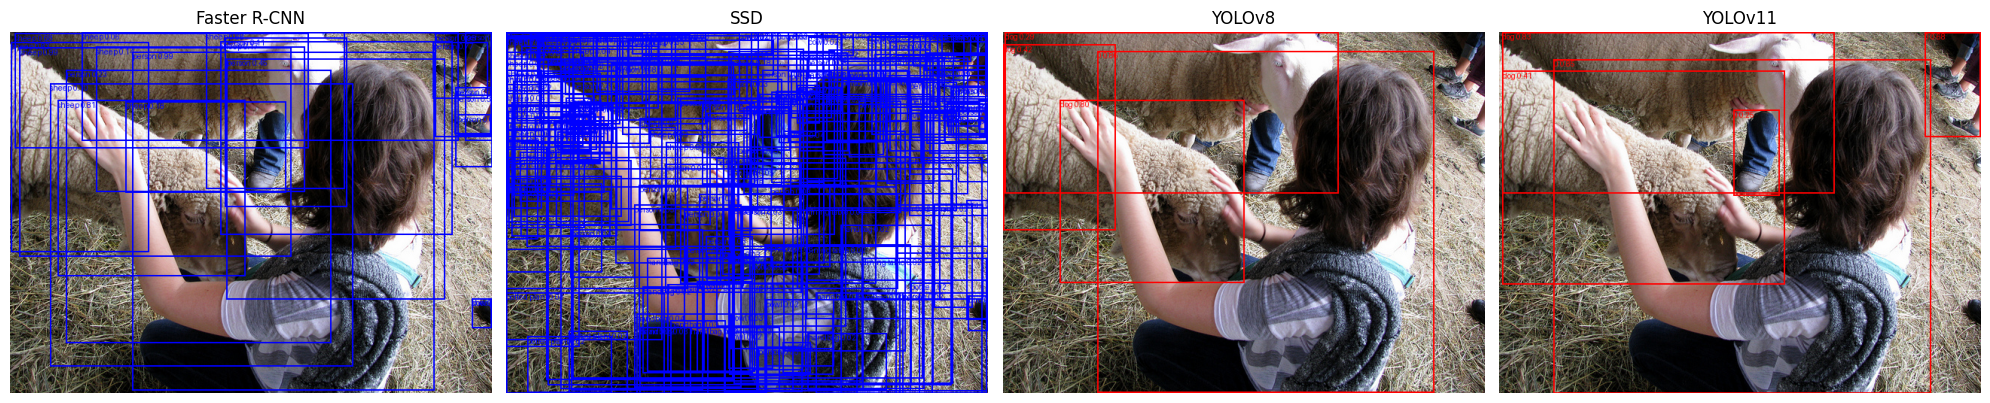


image 1/1 /content/data/coco/val2017/000000393226.jpg: 480x640 1 person, 4 cars, 2 trucks, 1 traffic light, 9.5ms
Speed: 3.2ms preprocess, 9.5ms inference, 2.2ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 /content/data/coco/val2017/000000393226.jpg: 480x640 1 person, 4 cars, 2 trucks, 12.9ms
Speed: 2.0ms preprocess, 12.9ms inference, 1.9ms postprocess per image at shape (1, 3, 480, 640)


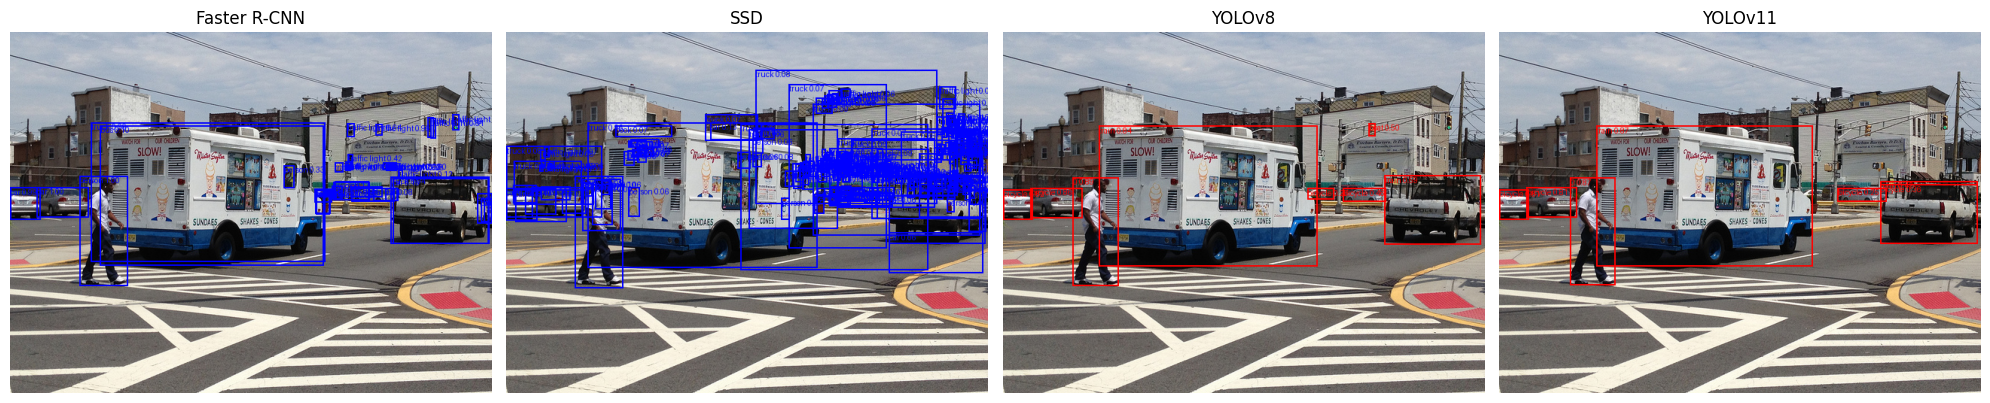


image 1/1 /content/data/coco/val2017/000000458768.jpg: 448x640 1 chair, 1 couch, 2 ovens, 10.0ms
Speed: 2.2ms preprocess, 10.0ms inference, 2.1ms postprocess per image at shape (1, 3, 448, 640)

image 1/1 /content/data/coco/val2017/000000458768.jpg: 448x640 1 couch, 2 ovens, 17.8ms
Speed: 1.8ms preprocess, 17.8ms inference, 1.9ms postprocess per image at shape (1, 3, 448, 640)


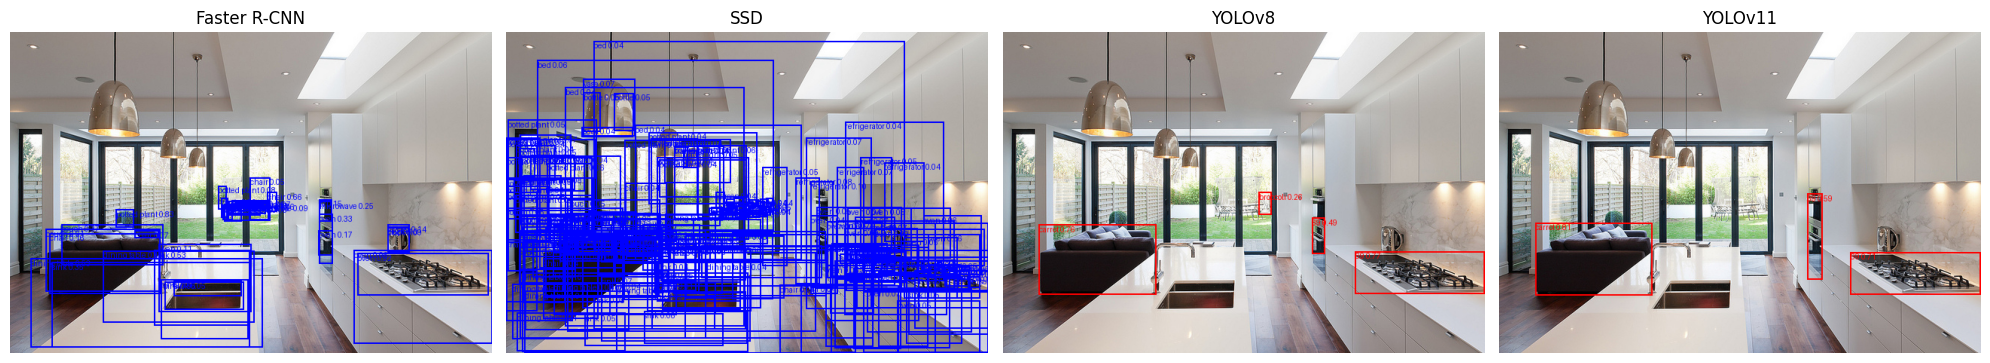


image 1/1 /content/data/coco/val2017/000000327701.jpg: 448x640 4 persons, 1 sports ball, 1 baseball bat, 9.6ms
Speed: 2.4ms preprocess, 9.6ms inference, 2.0ms postprocess per image at shape (1, 3, 448, 640)

image 1/1 /content/data/coco/val2017/000000327701.jpg: 448x640 4 persons, 1 sports ball, 1 tennis racket, 11.8ms
Speed: 1.9ms preprocess, 11.8ms inference, 1.9ms postprocess per image at shape (1, 3, 448, 640)


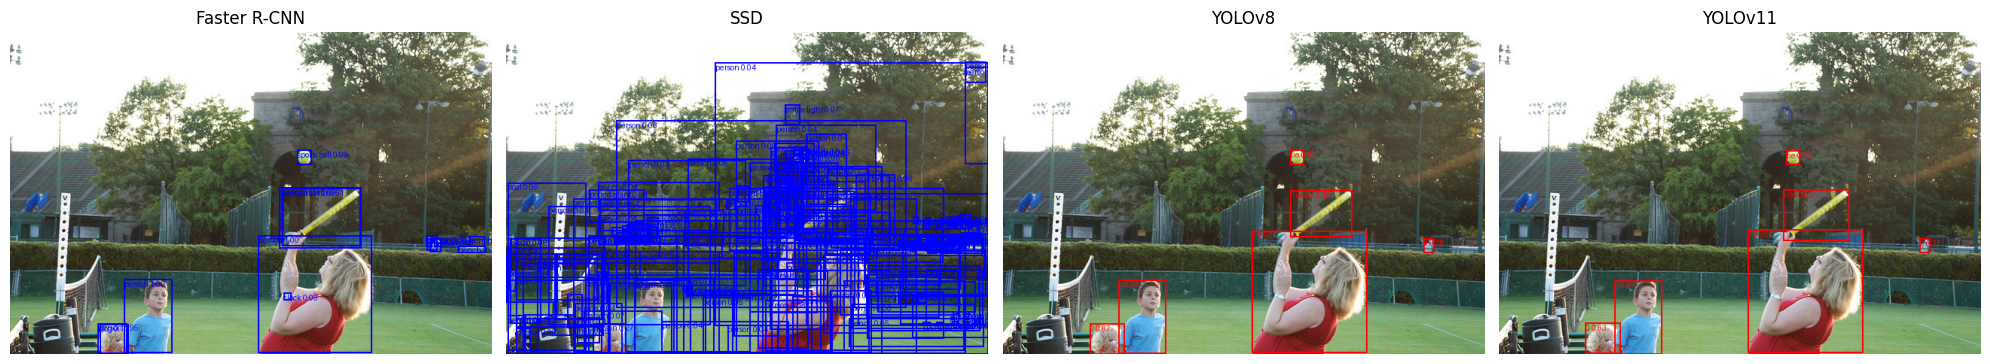


image 1/1 /content/data/coco/val2017/000000032811.jpg: 640x480 1 bird, 13.2ms
Speed: 4.2ms preprocess, 13.2ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 480)

image 1/1 /content/data/coco/val2017/000000032811.jpg: 640x480 1 bird, 1 tv, 14.1ms
Speed: 3.4ms preprocess, 14.1ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 480)


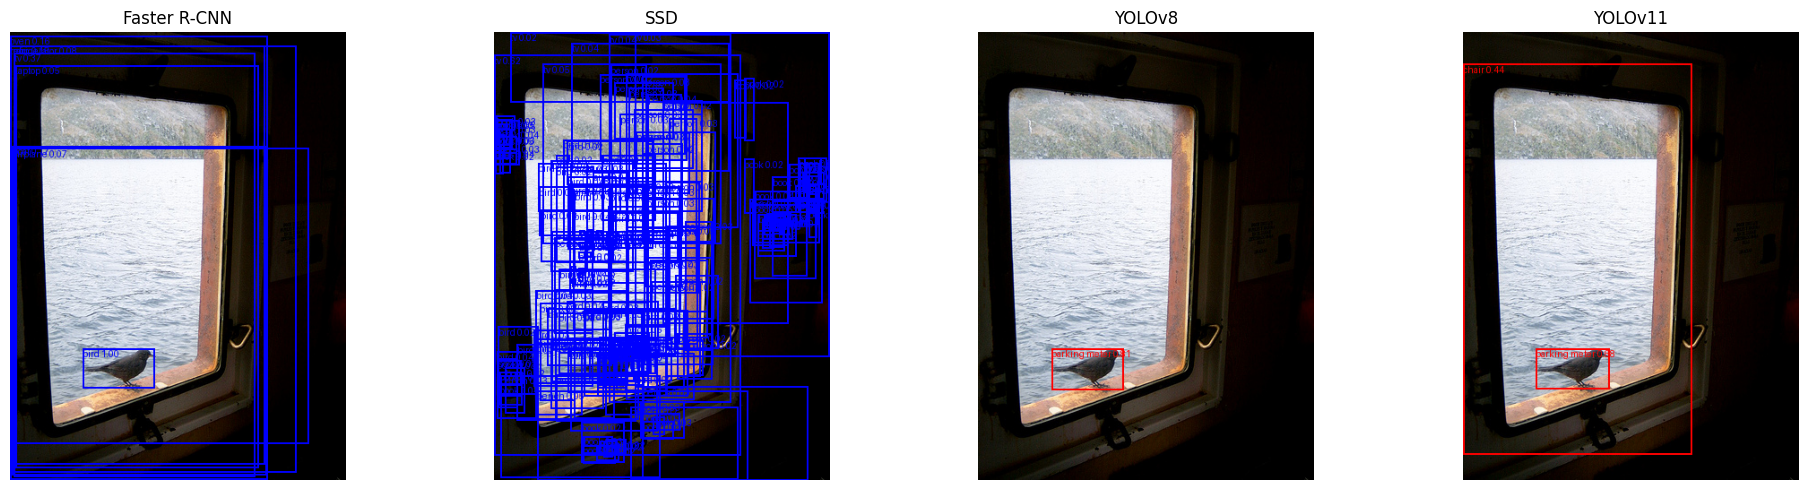

In [ ]:

# ✅ Visual Comparison of Predictions
for img_id in img_ids[:5]:
    path = coco.loadImgs(img_id)[0]['file_name']
    image_path = os.path.join("data/coco/val2017", path)
    fig, axs = plt.subplots(1, 4, figsize=(20, 5))
    axs[0].imshow(draw_boxes(image_path, faster_rcnn([faster_transform(Image.open(image_path).convert("RGB")).cuda()])[0:1]))
    axs[0].set_title("Faster R-CNN")
    axs[1].imshow(draw_boxes(image_path, ssd([faster_transform(Image.open(image_path).convert("RGB")).cuda()])[0:1]))
    axs[1].set_title("SSD")
    axs[2].imshow(draw_boxes(image_path, yolo.predict(image_path)[0], model_type="yolo"))
    axs[2].set_title("YOLOv8")
    axs[3].imshow(draw_boxes(image_path, yolo11.predict(image_path)[0], model_type="yolo"))
    axs[3].set_title("YOLOv11")
    for ax in axs: ax.axis("off")
    plt.tight_layout()
    plt.show()

In [ ]:
import time

# ✅ Function to estimate FPS
def estimate_fps(model, image_path, transform, is_yolo=False, warmup=1, runs=5):
    image = Image.open(image_path).convert("RGB")
    img_tensor = transform(image).unsqueeze(0).cuda()
    # Warm-up
    for _ in range(warmup):
        if is_yolo:
            model.predict(image_path, imgsz=640, conf=0.25)
        else:
            with torch.no_grad():
                model(img_tensor)
    # Timed inference
    start = time.time()
    for _ in range(runs):
        if is_yolo:
            model.predict(image_path, imgsz=640, conf=0.25)
        else:
            with torch.no_grad():
                model(img_tensor)
    end = time.time()
    avg_time = (end - start) / runs
    fps = 1 / avg_time
    return round(fps, 2)

# ✅ Use the first image to measure FPS
sample_img_path = os.path.join("data/coco/val2017", coco.loadImgs(img_ids[0])[0]['file_name'])

fps_frcnn = estimate_fps(faster_rcnn, sample_img_path, faster_transform)
fps_ssd = estimate_fps(ssd, sample_img_path, faster_transform)
fps_yolo8 = estimate_fps(yolo, sample_img_path, faster_transform, is_yolo=True)
fps_yolo11 = estimate_fps(yolo11, sample_img_path, faster_transform, is_yolo=True)

# ✅ Create final comparison DataFrame
comparison_df = pd.DataFrame({
    "Model": ["Faster R-CNN", "SSD", "YOLOv8", "YOLOv11"],
    "mAP@[.5:.95]": [round(faster_map, 3), round(ssd_map, 3), round(yolo_map, 3), round(yolo11_map, 3)],
    "FPS (est.)": [fps_frcnn, fps_ssd, fps_yolo8, fps_yolo11]
})

# ✅ Display final table
print("\n📊 Final Model Comparison:")
print(comparison_df.to_string(index=False))



image 1/1 /content/data/coco/val2017/000000458755.jpg: 480x640 1 person, 3 sheeps, 7.8ms
Speed: 2.0ms preprocess, 7.8ms inference, 1.4ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 /content/data/coco/val2017/000000458755.jpg: 480x640 1 person, 3 sheeps, 6.3ms
Speed: 1.3ms preprocess, 6.3ms inference, 1.3ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 /content/data/coco/val2017/000000458755.jpg: 480x640 1 person, 3 sheeps, 6.2ms
Speed: 1.3ms preprocess, 6.2ms inference, 1.3ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 /content/data/coco/val2017/000000458755.jpg: 480x640 1 person, 3 sheeps, 6.2ms
Speed: 1.3ms preprocess, 6.2ms inference, 1.3ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 /content/data/coco/val2017/000000458755.jpg: 480x640 1 person, 3 sheeps, 6.5ms
Speed: 1.3ms preprocess, 6.5ms inference, 1.4ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 /content/data/coco/val2017/000000458755.jpg: 480x640 1 pers